In [1]:
% matplotlib inline
import matplotlib.pyplot as pl
import numpy as np


# Categorize asteroid spectra
The goal of this seminar is to categolize asteroid spectra automaitcally with machine learning method.

## Visualization of data from files
### Download the ECAS data from PDS (Planetary data system)
Go to the PDS page (http://sbn.psi.edu/pds/resource/ecas.html) and download ECAS data (EAR-A-2CP-3-RDR-ECAS-V4.0). ECAS is the data from Eight Color Asteroid Survey.
ECAS had 8 vis-IR band filters and observed 589 asteroid spectra.
Please look at the label files for more detailed information.
This data is relatively old but simple, and so I choose this data for an exercise.
You can find more spectra data sets in PDS.

### Open and load the ECAS filter data (ecasfltr.tab)
The file 'ecasfltr.tab' includes the transmission data of ECAS. You can see the range of wavelength which passes through a filter.

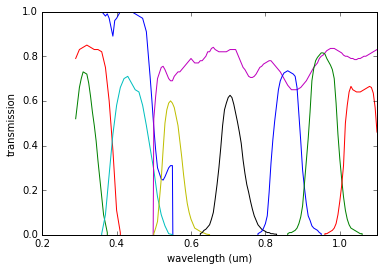

In [2]:
fname = 'ecasfltr.tab'
import os
home = os.environ['HOME']
fp=os.path.join(home, 'Python-seminar', fname)

filter=np.loadtxt(fp).T
pl.plot(filter[0],filter[1:].T)
pl.ylim(0,1)
pl.xlabel('wavelength (um)')
pl.ylabel('transmission')


### Open and load the ECAS catalog (ecas.tab)

In [3]:
ast_number=[]
ast_name=[]
s_v=[]
s_v_std_dev=[]
u_v=[]
u_v_std_dev=[]
b_v=[]
b_v_std_dev=[]
v_mag=[]
v_mag_std_dev=[]
v_w=[]
v_w_std_dev=[]
v_x=[]
v_x_std_dev=[]
v_p=[]
v_p_std_dev=[]
v_z=[]
v_z_std_dev=[]
obs_time=[]
cycles=[]

fname='ecas.tab'
fp=os.path.join(home, 'Python-seminar', fname)

for line in open(fp, 'r'):
    itemList = line[:-1].split()
#    print itemList
    ast_number.append(int(itemList[0]))
    ast_name.append((itemList[1]))
    s_v.append(float(itemList[2]))
    s_v_std_dev.append(float(itemList[3]))
    u_v.append(float(itemList[4]))
    u_v_std_dev.append(float(itemList[5]))
    b_v.append(float(itemList[6]))
    b_v_std_dev.append(float(itemList[7]))
    v_mag.append(float(itemList[8]))
    v_mag_std_dev.append(float(itemList[9]))
    v_w.append(float(itemList[10]))
    v_w_std_dev.append(float(itemList[11]))
    v_x.append(float(itemList[12]))
    v_x_std_dev.append(float(itemList[13]))
    v_p.append(float(itemList[14]))
    v_p_std_dev.append(float(itemList[15]))
    v_z.append(float(itemList[16]))
    v_z_std_dev.append(float(itemList[17]))
    obs_time.append(itemList[18])
    cycles.append(itemList[19])

ecas=[s_v,u_v,b_v,v_mag,v_w,v_x,v_p,v_z]
ecas=np.array(ecas)


### Screening of data
-9.99　is dummy number.

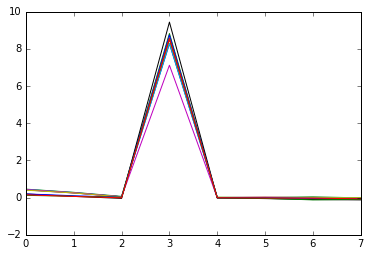

In [4]:
ecas_screen=ecas[:,(ecas[0]>-9.99)&(ecas[1]>-9.99)&(ecas[2]>-9.99)&(ecas[3]>-9.99)&(ecas[4]>-9.99)&(ecas[5]>-9.99)&(ecas[6]>-9.99)&(ecas[7]>-9.99)]

pl.plot(ecas_screen[:8,:10])

### Plotting
#### simplest plot

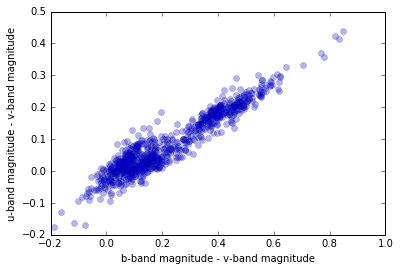

In [5]:
pl.plot(ecas_screen[1],ecas_screen[2],'o',alpha=0.3)
pl.xlabel('b-band magnitude - v-band magnitude')
pl.ylabel('u-band magnitude - v-band magnitude')
pl.show()

#### matrix plot

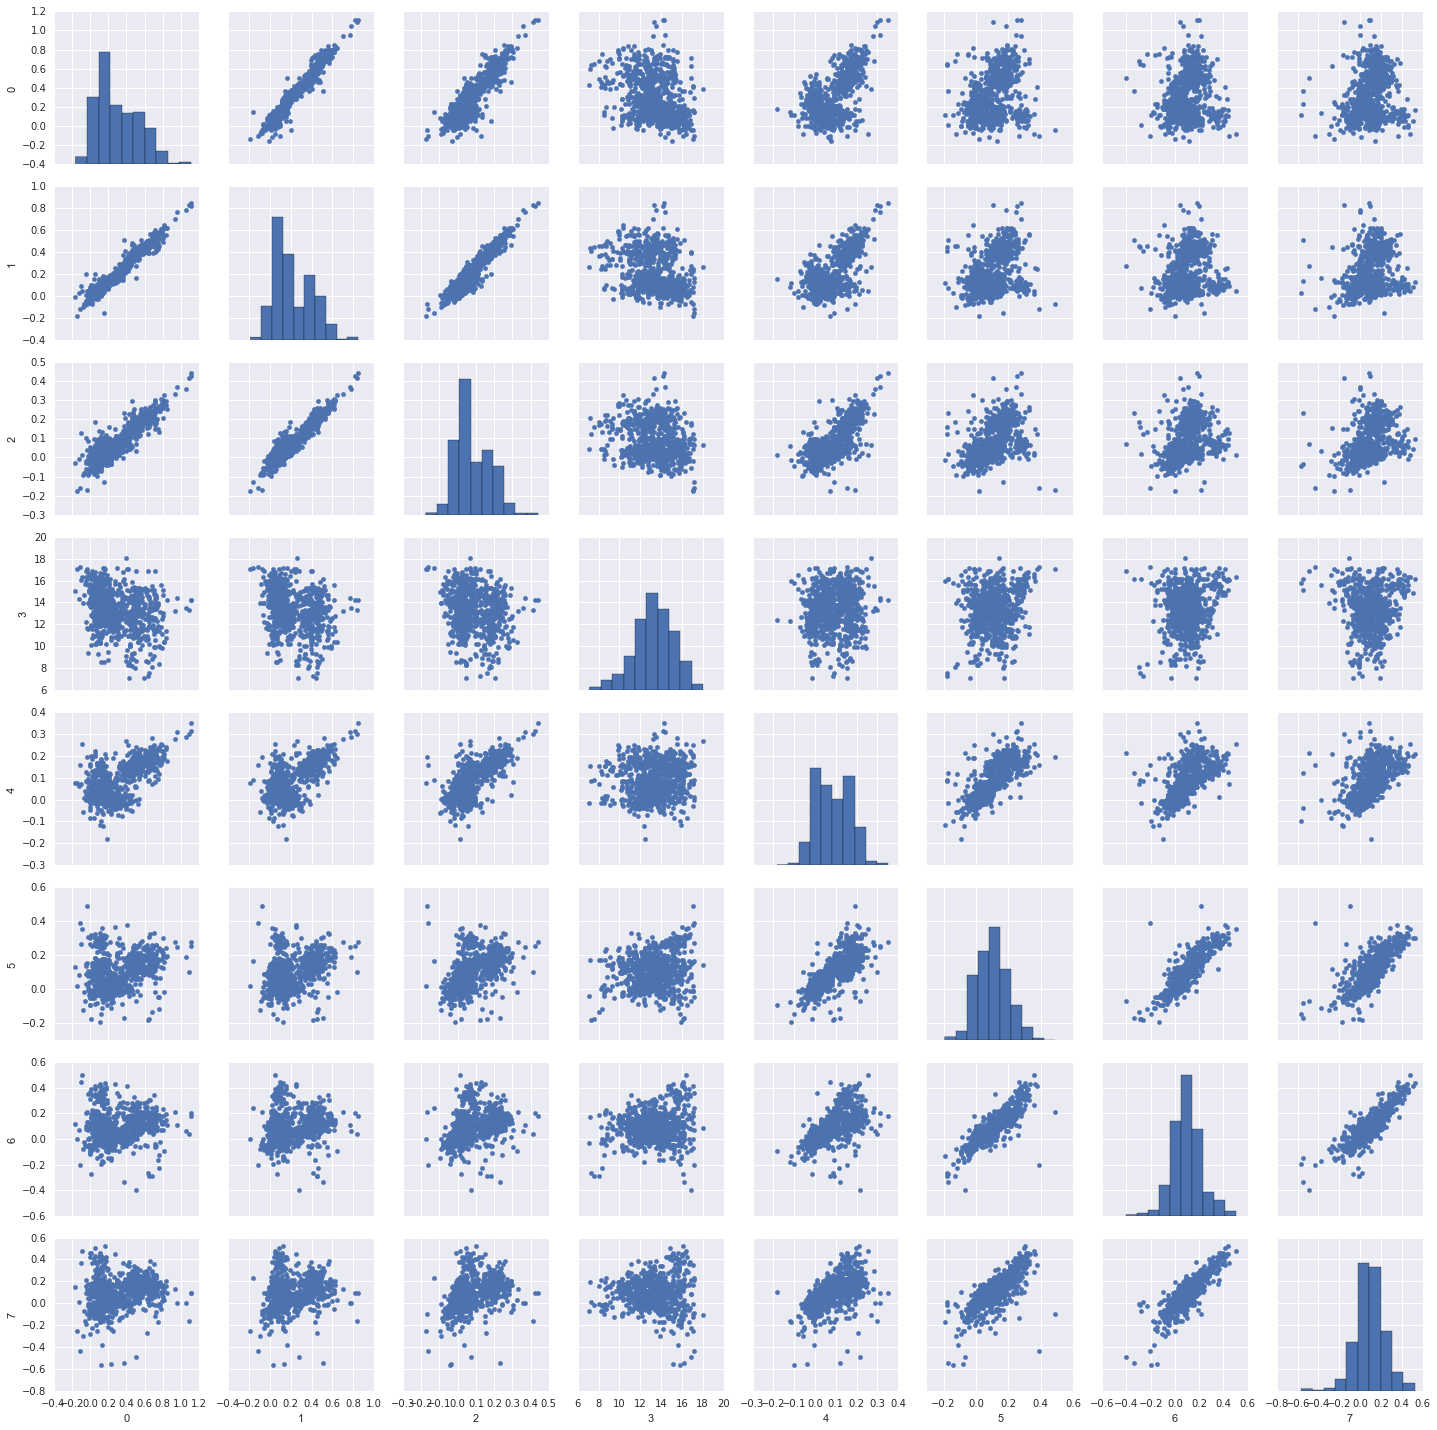

In [6]:
import seaborn as sns
import pandas as pd
df=pd.DataFrame(data=ecas_screen.T)
g = sns.PairGrid(df)
g = g.map_diag(pl.hist)
g = g.map_offdiag(pl.scatter)

### Magnitude to reflectance
$M-M_{ref}=2.5*log\left(\frac{R}{R_{ref}}\right)$

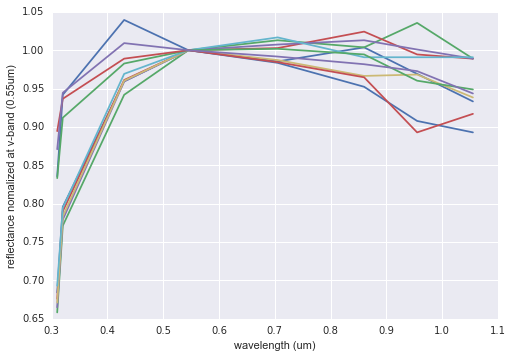

In [7]:
ecas_wl=[]
ecas_fwhm=[]
fname='ecasband.tab'
fp=os.path.join(home, 'Python-seminar', fname)

for line in open(fp,'r'):
    item=line[:-1].split()
    ecas_wl.append(float(item[1]))
    ecas_fwhm.append(float(item[2]))

ecas_ref=np.ones_like(ecas_screen)
ecas_ref[:3]=10**-(ecas_screen[:3]/2.5)
ecas_ref[3]=np.ones_like(ecas_screen[4])
ecas_ref[4:8]=10**+(ecas_screen[4:8]/2.5)

pl.plot(ecas_wl,ecas_ref[:8,:10])
pl.xlabel('wavelength (um)')
pl.ylabel('reflectance nomalized at v-band (0.55um)')



## Nomalize data

In [8]:
ecas_norm=np.ones_like(ecas_screen)
ave_spctr=[np.mean(ecas_ref[i]) for i in range(8)]
std_spctr=[np.std(ecas_ref[i]) for i in range(8)]
print ave_spctr
print std_spctr
for i in range(8):
    if i!=3:
        ecas_norm[i]=(ecas_ref[i]-np.mean(ecas_ref[i]))/np.std(ecas_ref[i])
    else:
        ecas_norm[i]=ecas_ref[3]

[0.77114621599213551, 0.82747653332892901, 0.92938469782329014, 1.0, 1.0869568046149554, 1.1041927517622085, 1.0997963229034706, 1.1023779820804915]
[0.15442605837311799, 0.12957007365770837, 0.079051160583724078, 0.0, 0.081912099718467829, 0.1014669316305425, 0.12021483732660217, 0.14207757395952356]


## Principal component analysis (PCA)
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [9]:
from sklearn.decomposition import PCA
print ecas_screen.shape
pca=PCA(n_components=8)
pca.fit(ecas_norm.T)
pc=pca.components_

print pca.explained_variance_

(8, 792)
[  4.27577044e+00   2.07269414e+00   3.22608601e-01   1.48766458e-01
   8.68554067e-02   7.55822535e-02   1.77227021e-02   1.03104309e-34]


we can neglect small explained variance components.

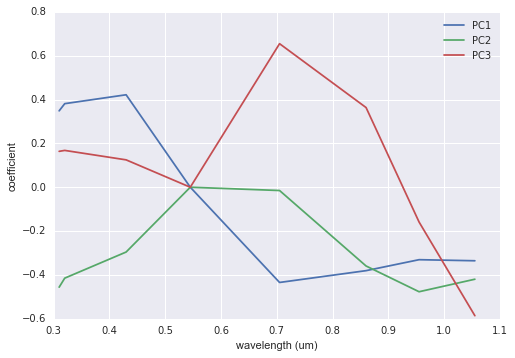

In [10]:
pc=pca.components_
pl.plot(ecas_wl,pc[:3].T)
pl.legend(['PC1','PC2','PC3'])
pl.xlabel('wavelength (um)')
pl.ylabel('coefficient')

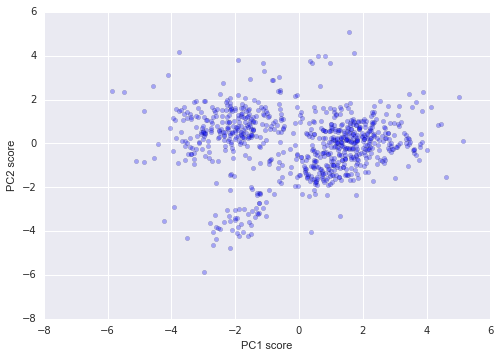

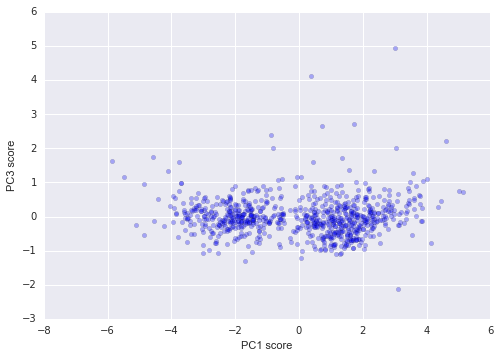

In [11]:
xd=pca.transform(ecas_norm.T)
pl.scatter(xd.T[0],xd.T[1],alpha=0.3)
pl.xlabel('PC1 score')
pl.ylabel('PC2 score')
pl.show()

pl.scatter(xd.T[0],xd.T[2],alpha=0.3)
pl.xlabel('PC1 score')
pl.ylabel('PC3 score')
pl.show()


## K-means clustering

In [12]:
from sklearn.cluster import KMeans
n=3 #caterorize into 3 groups
features=xd[:,:3] # use PC1 to PC2
kmeans_model = KMeans(n_clusters=n, random_state=10).fit(features)

#get cluster label
labels = kmeans_model.labels_


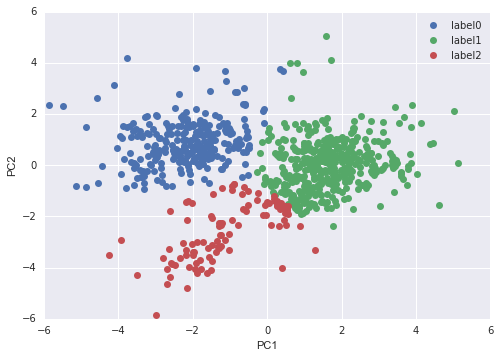

In [13]:
for i in range(n):
    pl.plot(xd[labels==i,0].T,xd[labels==i,1].T,'o',label='label'+str(i))

pl.xlabel('PC1')
pl.ylabel('PC2')
pl.legend()
pl.show()

## Inverse transform from PC space to original space

In [14]:
centers=kmeans_model.cluster_centers_
print centers

[[-2.18459982  0.89689468  0.06949773]
 [ 1.65681834  0.04570172 -0.03813699]
 [-1.11475084 -2.54562649 -0.02481945]]


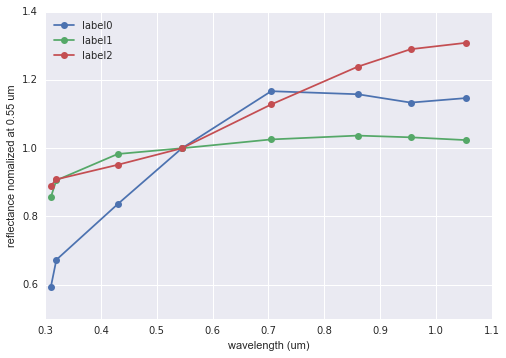

In [15]:
label0=(centers[0,0]*pc[0]+centers[0,1]*pc[1]+centers[0,2]*pc[2])*std_spctr+ave_spctr
label1=(centers[1,0]*pc[0]+centers[1,1]*pc[1]+centers[1,2]*pc[2])*std_spctr+ave_spctr
label2=(centers[2,0]*pc[0]+centers[2,1]*pc[1]+centers[2,2]*pc[2])*std_spctr+ave_spctr

pl.plot(ecas_wl,label0,'o-',label='label0')
pl.plot(ecas_wl,label1,'o-',label='label1')
pl.plot(ecas_wl,label2,'o-',label='label2')
pl.xlabel('wavelength (um)')
pl.ylabel('reflectance nomalized at 0.55 um')
pl.legend(loc=2)
pl.show()

## Factor analysis will be the next time... sorry